In [636]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.deterministic import DeterministicProcess
from statsmodels.tsa.deterministic import Fourier
from time import time

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV
from xgboost import XGBRegressor

<h3>Steps to be followed</h3>
<ol>
    <li>Read in data</li>
    <li>Find starting and ending dates for train and test sets</li>
    <li>Create date range containing all dates from start to end of training set with hourly frequency</li>
    <li>Create a feature for time data with hourly frequency</li>
    <li>Create lag features</li>
</ol>

<h4>Reading Dataset</h4>

In [637]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

train.date=pd.to_datetime(train.date)
test.date=pd.to_datetime(test.date)

<h4>Sorting train data by date and hour</h4>

In [638]:
train=train.sort_values(by=['date','hour'])
display(train.head())
print('train-shape: ',train.shape)
display(test.head())
print('test-shape: ',test.shape)

,date,hour,demand
0,2018-08-18,9,91
1,2018-08-18,10,21
2,2018-08-18,13,23
3,2018-08-18,14,104
4,2018-08-18,15,81


train-shape:  (18247, 3)


,date,hour
0,2021-03-01,0
1,2021-03-01,1
2,2021-03-01,2
3,2021-03-01,3
4,2021-03-01,5


test-shape:  (7650, 2)


<h4>Finding starting and ending dates for train and test sets</h4>

In [639]:
for title,df in [('Train',train),('Test',test)]:
    print(title+'\n'+'--'*30)
    print('Starting-date: ',df['date'].min())
    print('Ending-date: ',df['date'].max())
    print('\n')

Train
------------------------------------------------------------
Starting-date:  2018-08-18 00:00:00
Ending-date:  2021-02-28 00:00:00


Test
------------------------------------------------------------
Starting-date:  2021-03-01 00:00:00
Ending-date:  2022-03-28 00:00:00




In [640]:
# Generating hourly daterange for training data with hourly frequency
df1=pd.DataFrame({'combined_date':pd.date_range(start='2018-08-18',end='2021-02-28',freq='H')})

In [641]:
# merging hour column and datetime column
train['combined_date']=train.date.apply(lambda x:str(x))+' '+train.hour.apply(lambda x:str(x))+':00:00'
test['combined_date']=test.date.apply(lambda x:str(x))+' '+test.hour.apply(lambda x:str(x))+':00:00'

# converting new combined date column to datetime
train['combined_date']=pd.to_datetime(train['combined_date'])
test['combined_date']=pd.to_datetime(test['combined_date'])


In [642]:
# Merging df1 with train to get the full time index
df_train=pd.merge(df1,train,on='combined_date',how='left').drop(['date','hour'],axis=1).set_index('combined_date')
del(df1)

# filling NaN values with 0 since all missing timestamps can be assumed to have zero demand
df_train=df_train.fillna(0)

display(df_train.head())
print(df_train.shape)

,demand
combined_date,
2018-08-18 00:00:00,0.0
2018-08-18 01:00:00,0.0
2018-08-18 02:00:00,0.0
2018-08-18 03:00:00,0.0
2018-08-18 04:00:00,0.0


(22201, 1)


<h4>Creating fourier terms to capture seasonality</h4>

In [643]:
# creating a new time feature from the combined date column
dp=DeterministicProcess(index=df_train.index,
                       constant=False,
                       order=1,
                    additional_terms=[Fourier(period=12,order=1),
                                      Fourier(period=24,order=2)],
                       drop=True)
df1=dp.in_sample().rename(columns={'trend':'time1'})
df_train=pd.merge(df1,df_train,on='combined_date',how='inner')
df_train.head()

,time1,"sin(1,12)","cos(1,12)","sin(1,24)","cos(1,24)",demand
combined_date,,,,,,
2018-08-18 00:00:00,1.0,0.000000,1.000000e+00,0.000000,1.000000,0.0
2018-08-18 01:00:00,2.0,0.500000,8.660254e-01,0.258819,0.965926,0.0
2018-08-18 02:00:00,3.0,0.866025,5.000000e-01,0.500000,0.866025,0.0
2018-08-18 03:00:00,4.0,1.000000,6.123234e-17,0.707107,0.707107,0.0
2018-08-18 04:00:00,5.0,0.866025,-5.000000e-01,0.866025,0.500000,0.0


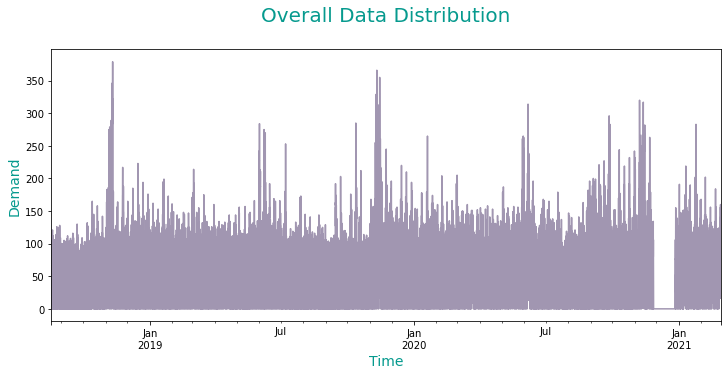

In [644]:
df_train['demand'].plot(figsize=(12,5),alpha=0.75,color='#827397')

# Setting title
plt.title('Overall Data Distribution\n',fontdict={'fontsize':20,'fontweight':5,'color':'#069A8E'})

# setting xlabels and ylabels
plt.xlabel('Time',fontdict={'fontsize':14,'fontweight':5,'color':'#069A8E'})
plt.ylabel('Demand',fontdict={'fontsize':14,'fontweight':5,'color':'#069A8E'});

It looks like data for the month of December,2020 is missing

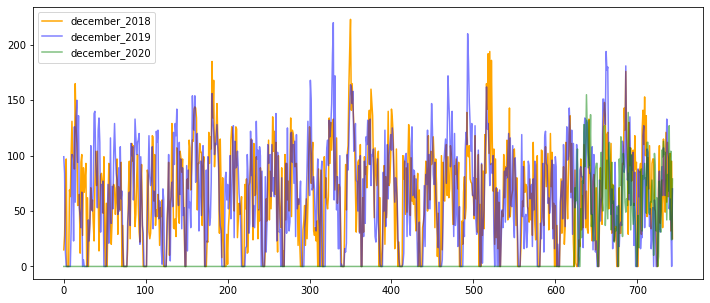

In [645]:
# Plotting data for december for 3 years
december_2018=df_train.loc[(df_train.index.year==2018) &(df_train.index.month==12)].reset_index()
december_2019=df_train.loc[(df_train.index.year==2019) &(df_train.index.month==12)].reset_index()
december_2020=df_train.loc[(df_train.index.year==2020) &(df_train.index.month==12)].reset_index()

december_2018['demand'].plot(figsize=(12,5),label='december_2018',color='orange')
december_2019['demand'].plot(figsize=(12,5),label='december_2019',color='blue',alpha=0.5)
december_2020['demand'].plot(figsize=(12,5),label='december_2020',color='green',alpha=0.5)


plt.legend();

December,2020 has missing data from 2020-12-01 to 2020-12-26. So these values will be replaced by average values from previous years

In [646]:
# Imputing missing values in december 2020 with average values from previous years

imputed_demand=0.5*(df_train.loc['2018-12-01':'2018-12-26','demand'].values+\
                    df_train.loc['2019-12-01':'2019-12-26','demand'].values)

df_train.loc['2020-12-01':'2020-12-26','demand']=imputed_demand

<AxesSubplot:xlabel='combined_date'>

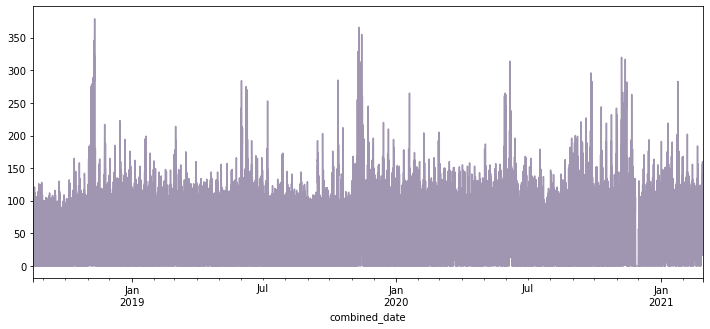

In [647]:
# Plotting the corrected data
df_train['demand'].plot(figsize=(12,5),alpha=0.75,color='#827397')

<h4>Creating Lag Features</h4>

In [648]:
def create_lag_features(df,col_names,n_lags=20):
    '''
    Creates lag_features from a list of features for a data frame
    
    Inputs
    ------------------------------
    df- the daataframe
    col_name--list of strings indicating column names from which features need to be created
    n_lags: number of lags to be created
    
    Outputs
    ------------------------------
    consolidated dataframe containing the lag features
    '''
    
    data=df.copy(deep=True)
    
    for col in col_names:
        for i in range(1,n_lags+1):
            data.loc[:,col+'_lag_'+str(i)]=data[col].shift(i)
    
    # fill NaN values with 0
    data.fillna(0,inplace=True)
    return data

<h4>Train-test-split</h4>
<p>
    Since the forecast needs to be made only for the month of March, test and validation sets will also be of 1 month each
</p>

In [649]:
df_train1=df_train.loc[:'2021-01-31']
X_test=df_train.loc['2021-02-01':]

print(df_train1.shape)
print(X_test.shape)

(21552, 6)
(649, 6)


In [650]:
# creating lag features
n_lags=30
df_train2=create_lag_features(df_train1,['demand'],n_lags=n_lags)

# create validation_set
X_val=df_train2.loc['2021-01-01':'2021-01-31'].drop('demand',axis=1)
y_val=df_train2.loc['2021-01-01':'2021-01-31','demand']

# Create training set
X_train=df_train2.loc[:'2020-12-31'].drop('demand',axis=1)
y_train=df_train2.loc[:'2020-12-31','demand']

In [651]:
# Exporting df_train2 for online training
# df_train2.to_csv('df_train2.csv')

<h3>Model Building</h3>

<h4>Linear Model</h4>

In [652]:
lr_model=LinearRegression()

lr_model.fit(X_train,y_train)
pred=pd.Series(lr_model.predict(X_val),index=y_val.index)
rmse=np.sqrt(mean_squared_error(y_val,pred))
print('val_RMSE: ',rmse)

val_RMSE:  35.382837195809756


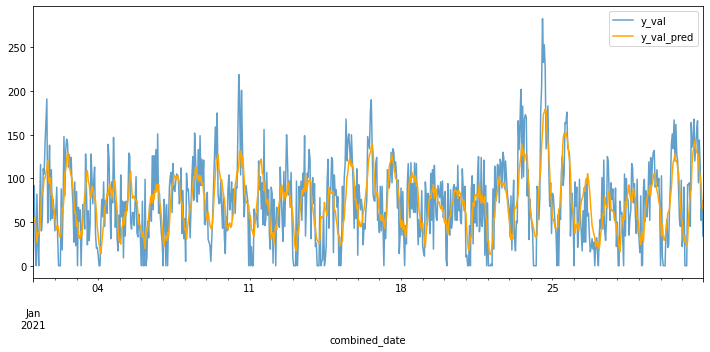

In [653]:
y_val.plot(figsize=(12,5),alpha=0.7,label='y_val');
pred.plot(alpha=1,color='orange',label='y_val_pred')
plt.legend();

<h4>XGBoost</h4>

In [654]:
xgb_model = XGBRegressor(
            n_estimators=1000,
            max_depth=5,
            min_child_weight=3,
            learning_rate=0.01,
            gamma=0.2,
            colsample_bytree=0.2)


xgb_model.fit(
    X_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, y_train), (X_val, y_val)], 
    verbose=True, 
    early_stopping_rounds = 30)

[0]	validation_0-rmse:76.62220	validation_1-rmse:85.70379
[1]	validation_0-rmse:76.02191	validation_1-rmse:85.04121
[2]	validation_0-rmse:75.45036	validation_1-rmse:84.42014
[3]	validation_0-rmse:74.88924	validation_1-rmse:83.80043
[4]	validation_0-rmse:74.31085	validation_1-rmse:83.16325
[5]	validation_0-rmse:73.73953	validation_1-rmse:82.53500
[6]	validation_0-rmse:73.16966	validation_1-rmse:81.90079
[7]	validation_0-rmse:72.65211	validation_1-rmse:81.33047
[8]	validation_0-rmse:72.10317	validation_1-rmse:80.71923
[9]	validation_0-rmse:71.58944	validation_1-rmse:80.15628
[10]	validation_0-rmse:71.07799	validation_1-rmse:79.59049
[11]	validation_0-rmse:70.55196	validation_1-rmse:79.02873
[12]	validation_0-rmse:70.03825	validation_1-rmse:78.46898
[13]	validation_0-rmse:69.54152	validation_1-rmse:77.93784
[14]	validation_0-rmse:69.03413	validation_1-rmse:77.38090
[15]	validation_0-rmse:68.55228	validation_1-rmse:76.85233
[16]	validation_0-rmse:68.04164	validation_1-rmse:76.29821
[17]	va

[139]	validation_0-rmse:37.95549	validation_1-rmse:42.51101
[140]	validation_0-rmse:37.87606	validation_1-rmse:42.40817
[141]	validation_0-rmse:37.79283	validation_1-rmse:42.31293
[142]	validation_0-rmse:37.70777	validation_1-rmse:42.21506
[143]	validation_0-rmse:37.61105	validation_1-rmse:42.09965
[144]	validation_0-rmse:37.52452	validation_1-rmse:41.99820
[145]	validation_0-rmse:37.42674	validation_1-rmse:41.88258
[146]	validation_0-rmse:37.34915	validation_1-rmse:41.78208
[147]	validation_0-rmse:37.27358	validation_1-rmse:41.69022
[148]	validation_0-rmse:37.19567	validation_1-rmse:41.59502
[149]	validation_0-rmse:37.11467	validation_1-rmse:41.49883
[150]	validation_0-rmse:37.04163	validation_1-rmse:41.41493
[151]	validation_0-rmse:36.96169	validation_1-rmse:41.32102
[152]	validation_0-rmse:36.88741	validation_1-rmse:41.23415
[153]	validation_0-rmse:36.81204	validation_1-rmse:41.14250
[154]	validation_0-rmse:36.73866	validation_1-rmse:41.05098
[155]	validation_0-rmse:36.66654	validat

[276]	validation_0-rmse:32.54979	validation_1-rmse:35.98298
[277]	validation_0-rmse:32.53856	validation_1-rmse:35.97387
[278]	validation_0-rmse:32.52581	validation_1-rmse:35.96222
[279]	validation_0-rmse:32.50995	validation_1-rmse:35.94641
[280]	validation_0-rmse:32.49913	validation_1-rmse:35.93415
[281]	validation_0-rmse:32.48692	validation_1-rmse:35.91732
[282]	validation_0-rmse:32.47415	validation_1-rmse:35.90391
[283]	validation_0-rmse:32.45663	validation_1-rmse:35.87962
[284]	validation_0-rmse:32.44466	validation_1-rmse:35.86452
[285]	validation_0-rmse:32.43525	validation_1-rmse:35.85503
[286]	validation_0-rmse:32.42135	validation_1-rmse:35.84110
[287]	validation_0-rmse:32.40781	validation_1-rmse:35.82815
[288]	validation_0-rmse:32.39542	validation_1-rmse:35.81438
[289]	validation_0-rmse:32.38453	validation_1-rmse:35.80349
[290]	validation_0-rmse:32.37499	validation_1-rmse:35.79474
[291]	validation_0-rmse:32.36079	validation_1-rmse:35.77936
[292]	validation_0-rmse:32.35036	validat

[413]	validation_0-rmse:31.49639	validation_1-rmse:35.03435
[414]	validation_0-rmse:31.49289	validation_1-rmse:35.03360
[415]	validation_0-rmse:31.48865	validation_1-rmse:35.03138
[416]	validation_0-rmse:31.48216	validation_1-rmse:35.02646
[417]	validation_0-rmse:31.47918	validation_1-rmse:35.02560
[418]	validation_0-rmse:31.47520	validation_1-rmse:35.02305
[419]	validation_0-rmse:31.46997	validation_1-rmse:35.01977
[420]	validation_0-rmse:31.46539	validation_1-rmse:35.01837
[421]	validation_0-rmse:31.46313	validation_1-rmse:35.01720
[422]	validation_0-rmse:31.45707	validation_1-rmse:35.01090
[423]	validation_0-rmse:31.45305	validation_1-rmse:35.00614
[424]	validation_0-rmse:31.44862	validation_1-rmse:35.00805
[425]	validation_0-rmse:31.44232	validation_1-rmse:35.00323
[426]	validation_0-rmse:31.43653	validation_1-rmse:34.99991
[427]	validation_0-rmse:31.43332	validation_1-rmse:34.99921
[428]	validation_0-rmse:31.42711	validation_1-rmse:34.99698
[429]	validation_0-rmse:31.42379	validat

[550]	validation_0-rmse:30.97655	validation_1-rmse:34.82902
[551]	validation_0-rmse:30.97332	validation_1-rmse:34.83036
[552]	validation_0-rmse:30.96994	validation_1-rmse:34.83185
[553]	validation_0-rmse:30.96616	validation_1-rmse:34.82653
[554]	validation_0-rmse:30.96209	validation_1-rmse:34.82496
[555]	validation_0-rmse:30.96049	validation_1-rmse:34.82519
[556]	validation_0-rmse:30.95664	validation_1-rmse:34.82215
[557]	validation_0-rmse:30.95259	validation_1-rmse:34.82222
[558]	validation_0-rmse:30.94906	validation_1-rmse:34.82071
[559]	validation_0-rmse:30.94520	validation_1-rmse:34.81554
[560]	validation_0-rmse:30.94180	validation_1-rmse:34.81542
[561]	validation_0-rmse:30.93865	validation_1-rmse:34.81640
[562]	validation_0-rmse:30.93590	validation_1-rmse:34.81545
[563]	validation_0-rmse:30.93255	validation_1-rmse:34.81500
[564]	validation_0-rmse:30.92976	validation_1-rmse:34.81645
[565]	validation_0-rmse:30.92636	validation_1-rmse:34.81497
[566]	validation_0-rmse:30.92336	validat

[687]	validation_0-rmse:30.58506	validation_1-rmse:34.74762
[688]	validation_0-rmse:30.58221	validation_1-rmse:34.74637
[689]	validation_0-rmse:30.57853	validation_1-rmse:34.74616
[690]	validation_0-rmse:30.57496	validation_1-rmse:34.74682
[691]	validation_0-rmse:30.57240	validation_1-rmse:34.74823
[692]	validation_0-rmse:30.57120	validation_1-rmse:34.74902
[693]	validation_0-rmse:30.56884	validation_1-rmse:34.74929
[694]	validation_0-rmse:30.56584	validation_1-rmse:34.74919
[695]	validation_0-rmse:30.56247	validation_1-rmse:34.74781
[696]	validation_0-rmse:30.55943	validation_1-rmse:34.74700
[697]	validation_0-rmse:30.55704	validation_1-rmse:34.74617
[698]	validation_0-rmse:30.55537	validation_1-rmse:34.74686
[699]	validation_0-rmse:30.55351	validation_1-rmse:34.74563
[700]	validation_0-rmse:30.55195	validation_1-rmse:34.74528
[701]	validation_0-rmse:30.54869	validation_1-rmse:34.74724
[702]	validation_0-rmse:30.54536	validation_1-rmse:34.74567
[703]	validation_0-rmse:30.54395	validat

[824]	validation_0-rmse:30.26786	validation_1-rmse:34.68332
[825]	validation_0-rmse:30.26538	validation_1-rmse:34.68120
[826]	validation_0-rmse:30.26319	validation_1-rmse:34.67961
[827]	validation_0-rmse:30.26045	validation_1-rmse:34.67805
[828]	validation_0-rmse:30.25861	validation_1-rmse:34.67683
[829]	validation_0-rmse:30.25627	validation_1-rmse:34.67684
[830]	validation_0-rmse:30.25434	validation_1-rmse:34.67776
[831]	validation_0-rmse:30.25254	validation_1-rmse:34.67757
[832]	validation_0-rmse:30.25031	validation_1-rmse:34.67630
[833]	validation_0-rmse:30.24754	validation_1-rmse:34.67649
[834]	validation_0-rmse:30.24506	validation_1-rmse:34.67650
[835]	validation_0-rmse:30.24363	validation_1-rmse:34.67652
[836]	validation_0-rmse:30.24306	validation_1-rmse:34.67671
[837]	validation_0-rmse:30.24027	validation_1-rmse:34.67513
[838]	validation_0-rmse:30.23758	validation_1-rmse:34.67289
[839]	validation_0-rmse:30.23516	validation_1-rmse:34.67284
[840]	validation_0-rmse:30.23220	validat

[961]	validation_0-rmse:29.96141	validation_1-rmse:34.63125
[962]	validation_0-rmse:29.95918	validation_1-rmse:34.63016
[963]	validation_0-rmse:29.95870	validation_1-rmse:34.63012
[964]	validation_0-rmse:29.95719	validation_1-rmse:34.62863
[965]	validation_0-rmse:29.95444	validation_1-rmse:34.62997
[966]	validation_0-rmse:29.95267	validation_1-rmse:34.62985
[967]	validation_0-rmse:29.95021	validation_1-rmse:34.62823
[968]	validation_0-rmse:29.94770	validation_1-rmse:34.62514
[969]	validation_0-rmse:29.94556	validation_1-rmse:34.62437
[970]	validation_0-rmse:29.94371	validation_1-rmse:34.62491
[971]	validation_0-rmse:29.94210	validation_1-rmse:34.62525
[972]	validation_0-rmse:29.94158	validation_1-rmse:34.62564
[973]	validation_0-rmse:29.93920	validation_1-rmse:34.62700
[974]	validation_0-rmse:29.93711	validation_1-rmse:34.62698
[975]	validation_0-rmse:29.93494	validation_1-rmse:34.62754
[976]	validation_0-rmse:29.93207	validation_1-rmse:34.62356
[977]	validation_0-rmse:29.93012	validat

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.2, gamma=0.2, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=5,
             min_child_weight=3, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [655]:
pred=pd.Series(xgb_model.predict(X_val),index=y_val.index)
rmse=np.sqrt(mean_squared_error(y_val,pred))
print(rmse)

34.61727087537178


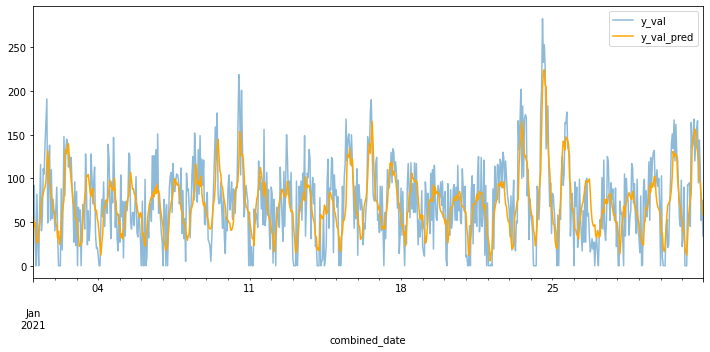

In [656]:
y_val.plot(figsize=(12,5),alpha=0.5,label='y_val');
pred.plot(alpha=1,color='orange',label='y_val_pred')
plt.legend();

<h3>Forecasting</h3>

In [657]:
X_train2=pd.concat([X_train,X_val],axis=0)
y_train2=pd.concat([y_train,y_val],axis=0)

# predict next 649 values for X_test
# xgb_model.predict(X_train2.iloc[-1:])[0]
# X_train2.tail(24)
X_train2.tail()

,time1,"sin(1,12)","cos(1,12)","sin(1,24)","cos(1,24)",demand_lag_1,demand_lag_2,demand_lag_3,demand_lag_4,demand_lag_5,...,demand_lag_21,demand_lag_22,demand_lag_23,demand_lag_24,demand_lag_25,demand_lag_26,demand_lag_27,demand_lag_28,demand_lag_29,demand_lag_30
combined_date,,,,,,,,,,,,,,,,,,,,,
2021-01-31 19:00:00,21548.0,-0.500000,-8.660254e-01,-0.965926,0.258819,95.0,166.0,154.0,138.0,120.0,...,45.0,52.0,85.0,120.0,127.0,162.0,120.0,167.0,134.0,151.0
2021-01-31 20:00:00,21549.0,-0.866025,-5.000000e-01,-0.866025,0.500000,144.0,95.0,166.0,154.0,138.0,...,98.0,45.0,52.0,85.0,120.0,127.0,162.0,120.0,167.0,134.0
2021-01-31 21:00:00,21550.0,-1.000000,-6.902982e-13,-0.707107,0.707107,113.0,144.0,95.0,166.0,154.0,...,22.0,98.0,45.0,52.0,85.0,120.0,127.0,162.0,120.0,167.0
2021-01-31 22:00:00,21551.0,-0.866025,5.000000e-01,-0.500000,0.866025,52.0,113.0,144.0,95.0,166.0,...,37.0,22.0,98.0,45.0,52.0,85.0,120.0,127.0,162.0,120.0
2021-01-31 23:00:00,21552.0,-0.500000,8.660254e-01,-0.258819,0.965926,75.0,52.0,113.0,144.0,95.0,...,90.0,37.0,22.0,98.0,45.0,52.0,85.0,120.0,127.0,162.0


In [674]:
n_steps=24

X_ex=X_train2.copy(deep=True).reset_index().drop('combined_date',axis=1)
y_ex=y_train2.copy(deep=True).values


for step in range(n_steps):
    
    ## Extract last row of X_ex
    x1=X_ex.iloc[-1:]
    new_idx=x1.index.values[0]+1
#     print(new_idx)
    x1=x1.rename(index={x1.index.values[0]:new_idx})

    # increase value of time by 1
    x1.loc[new_idx,'time1']+=1
    # display(x1)

    # shift lag values by 1 column to the right
    for lag in range(n_lags,1,-1):
        x1.loc[new_idx,'demand_lag_'+str(lag)]=x1.loc[new_idx,'demand_lag_'+str(lag-1)]

    # modyfying value of first lag
    x1.loc[new_idx,'demand_lag_1']=y_ex[-1]

    # predicting new y value
    y_ex=np.append(y_ex,xgb_model.predict(x1)[0])

    # appending new row to the main feature matrix
    X_ex=pd.concat([X_ex,x1],axis=0)
    
#     # retraining model every 24 steps
#     if step%24==0:
#         lr_model.fit(X_ex,y_ex)

display(X_ex.tail())
print(len(y_ex))

,time1,"sin(1,12)","cos(1,12)","sin(1,24)","cos(1,24)",demand_lag_1,demand_lag_2,demand_lag_3,demand_lag_4,demand_lag_5,...,demand_lag_21,demand_lag_22,demand_lag_23,demand_lag_24,demand_lag_25,demand_lag_26,demand_lag_27,demand_lag_28,demand_lag_29,demand_lag_30
21571,21572.0,-0.5,0.866025,-0.258819,0.965926,78.396111,83.936226,80.817711,86.194550,92.339752,...,75.000000,52.000000,113.000000,144.0,95.0,166.0,154.0,138.0,120.0,168.0
21572,21573.0,-0.5,0.866025,-0.258819,0.965926,65.944260,78.396111,83.936226,80.817711,86.194550,...,34.000000,75.000000,52.000000,113.0,144.0,95.0,166.0,154.0,138.0,120.0
21573,21574.0,-0.5,0.866025,-0.258819,0.965926,67.614281,65.944260,78.396111,83.936226,80.817711,...,54.551449,34.000000,75.000000,52.0,113.0,144.0,95.0,166.0,154.0,138.0
21574,21575.0,-0.5,0.866025,-0.258819,0.965926,66.356583,67.614281,65.944260,78.396111,83.936226,...,50.890629,54.551449,34.000000,75.0,52.0,113.0,144.0,95.0,166.0,154.0
21575,21576.0,-0.5,0.866025,-0.258819,0.965926,61.186546,66.356583,67.614281,65.944260,78.396111,...,51.259010,50.890629,54.551449,34.0,75.0,52.0,113.0,144.0,95.0,166.0


21576


In [681]:
start=21522
end=21522+n_steps
print(y_ex[start:end])
X_test.loc[(X_test.time1<=end)]

[127. 120.  85.  52.  45.  98.  22.  37.  90.   0.   0.   0.  93.  93.
  95.  45. 164. 136. 140. 168. 120. 138. 154. 166.]


,time1,"sin(1,12)","cos(1,12)","sin(1,24)","cos(1,24)",demand
combined_date,,,,,,


In [676]:
np.sqrt(mean_squared_error(orig,pred))

28.208343044199726

In [684]:
end

21546